In [1]:
import os

HOME = os.getcwd()
print(HOME)

c:\Users\DAAI.DESKTOP-128VDS1\Documents\deva\mfs\final_client_version


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from scipy.spatial import distance as dist
from numpy.linalg import norm

In [227]:
from key_point_extractor_utils import get_rectangles # using layouts 
from extract_pp_from_masks import extract_pp_from_masks # using masks

class MaskBlender:
    def __init__(self, layout_path, mat_path, seg_masks, src_path):
        self.layout_path = layout_path
        self.layout_img = cv2.imread(layout_path)
        self.mat_path = mat_path
        
        self.src_img = cv2.cvtColor(cv2.imread(src_path), cv2.COLOR_BGR2RGB)
        
        self.all_masks = self.__read_imgs(seg_masks)
        

        self.all_rectangles_m = extract_pp_from_masks(self.all_masks)
        self.rectangles_l = get_rectangles(self.layout_path, self.mat_path)
        self.all_rectangles_l = -1
        # print(self.rectangles_l)
        if self.rectangles_l != -1:
            self.all_rectangles_l = self.rectangles_l[1].copy()
            self.all_rectangles_l.extend(self.rectangles_l[0])



        # processed_img_variables
        self.all_rectangles = None
        self.rescaled_subject = None
    
        self.selected_warp = None
        self.selected_gray_mask = None
        
        self.transformed_warp = None    
        self.final_out = self.src_img.copy()


    def __read_imgs(self, seg_masks):
        mask_imgs = []
        for img in os.listdir(seg_masks):
            if img.split('.')[-1] == 'png':
                mask_imgs.append(seg_masks+"/"+img)

        # print(mask_imgs)
        masks = []
        for img in mask_imgs:
            mask = cv2.imread(img, 0)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            ret, bw_img = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
            # print(bw_img.shape)
            # plt.imshow(mask)    
            masks.append(bw_img)    
        return masks

    def pick_random_cord(self, mask):
        y, x = np.where(mask == [255, 255, 255])[:2]
        cords = list(zip(x, y))
        return random.choice(cords)

    def __give_user_options(self):
        n_walls = len(self.all_masks) - 1
        n_floors = 1
        options_cords = {}
        opt_list = {}

        opt_list[0] = "Floor"
        options_cords[0] = self.pick_random_cord(self.all_masks[0])
        for i in range(n_walls):
            opt_list[i+1] = "Wall"+str(i+1)
            options_cords[i+1] = self.pick_random_cord(self.all_masks[i+1])
        print(opt_list)
        return options_cords

    def find_rectangle_manually(self, given_mask):
        mask = np.array(given_mask)
        gray_mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
        # print(*gray_mask[400])
        row_ind = []
        for i in range(gray_mask.shape[0]):
            inds = np.where(gray_mask[i] == 255)[0]
            if inds.size != 0:
                row_ind.append(i)
        top, bottom = row_ind[0], row_ind[-1]
        
        col_ind = []
        for i in range(gray_mask.shape[1]):
            inds = np.where(gray_mask[:, i] == 255)[0]
            if inds.size != 0:
                col_ind.append(i)
        left, right = col_ind[0], col_ind[-1]

        return [[left, top],
                [right, top],
                [right, bottom],
                [left, bottom]
            ]
    
    def __rect_isIn(self, point, rectangle):
        x, y = point
        vertices = np.append(rectangle, [rectangle[0]], axis=0)
    
        crossing_number = 0
        for i in range(len(vertices) - 1):
            x1, y1 = vertices[i]
            x2, y2 = vertices[i + 1]
            if ((y1 <= y < y2) or (y2 <= y < y1)) and (x < (x1 - x2) * (y - y2) / (y1 - y2) + x2):
                crossing_number += 1
        return crossing_number % 2 == 1

    def __mask_is_in(self, point, mask):
        rect = self.find_rectangle_manually(mask)
        # print(rect)
        return self.__rect_isIn(point, rect)

    def findRectangle_from_cursor(self, rectangles, cursorPosition):
        for rect in rectangles:
            if self.__rect_isIn(cursorPosition, rect):
                return rect
        return -1

    def findMask_from_cursor(self, all_masks, cursorPosition):
        for mask in all_masks:
            if self.__mask_is_in(cursorPosition, mask):
                return mask
        return -1
        


    def __rescale_subject_img(self, subject_path, scale_percent):
        temp = cv2.imread(subject_path)
        subject_img = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
        
        w_rescale, h_rescale = (subject_img.shape[1]*scale_percent)//100, (subject_img.shape[0]*scale_percent)//100
        h, w = subject_img.shape[:-1]
        self.rescaled_subject = cv2.resize(subject_img, [w_rescale, h_rescale], interpolation=cv2.INTER_AREA)
        
    def __calculate_w_h(self, polygon):
        n_pts = len(polygon)
        edge_2 = polygon[1:-1]
        edge_3 = polygon[2:]
        all_distances = {}
        
        for edge in [edge_2, edge_3]:
            p1 = edge[0]
            p2 = edge[1]
            # print(p1, p2)
            dist = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
            all_distances[dist] = [p1, p2]
            # print(all_distances)
        return [*all_distances.keys()]
    
    def __replicate_subject(self, polygon):
        h_subject, w_subject = self.rescaled_subject.shape[:2]

        # print(polygon)
        h_base, _ = self.layout_img.shape[:2]
        _, w_base = self.__calculate_w_h(polygon)
        
        num_of_tiles_per_row = round(_ / h_subject)
        num_of_tiles_per_col = round(w_base / w_subject)
        # print(num_of_tiles_per_row, num_of_tiles_per_col)

        dup_cols = self.rescaled_subject.copy()
        ## duplicate the subject image
        for i in range(num_of_tiles_per_col):
            dup_cols = np.concatenate([dup_cols, self.rescaled_subject], axis = 1)
        dup_rows = dup_cols.copy()
        for i in range(num_of_tiles_per_row):
            dup_rows = np.concatenate([dup_rows, dup_cols], axis=0)
        
        duplicated_tiles = dup_rows.copy()
        plt.imshow(duplicated_tiles)
        return duplicated_tiles
    
    def perspective_warp(self, polygon):
        if len(polygon) > 4:
            sorted_pts = self.__reduce_points(polygon)
        else:
            sorted_pts = polygon
        
        # print(sorted_pts)
        duplicated_sub = self.__replicate_subject(sorted_pts)
        # plt.imshow(duplicated_sub)
        h_base, w_base, c_base = self.layout_img.shape
        h_subject, w_subject = duplicated_sub.shape[:2]
        pts1 = np.float32([[0, 0], [w_subject, 0], [w_subject, h_subject], [0, h_subject]])
        pts2 = np.float32(sorted_pts)
        # print(pts1, pts2)

        transformation_matrix = cv2.getPerspectiveTransform(pts1, pts2)
        # print(transformation_matrix)
        warped_img = cv2.warpPerspective(duplicated_sub, transformation_matrix, (w_base, h_base))
        # plt.imshow(warped_img)
        return warped_img

    def __combine_masks(self):
        combine_masks = np.zeros(self.layout_img.shape, dtype=np.uint8)
        for mask in self.all_masks:
            combine_masks = cv2.bitwise_or(combine_masks, mask)
        self.selected_gray_mask = cv2.cvtColor(combine_masks, cv2.COLOR_RGB2GRAY)

    def __combine_warps(self):        
        combined_warp = np.zeros(self.layout_img.shape, dtype=np.uint8)
        # print(self.all_rectangles)
        for polygon in self.all_rectangles:
            warp = self.perspective_warp(polygon)
            combined_warp = cv2.bitwise_or(combined_warp, warp)
        plt.imshow(combined_warp)
        return combined_warp
    
    def convert_png_save(self, transformed_warp):
        tmp = cv2.cvtColor(transformed_warp, cv2.COLOR_BGR2GRAY)
        _, alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)
        b, g, r = cv2.split(transformed_warp)
        
        rgba = [r, g, b, alpha]
        dst = cv2.merge(rgba, 4)
        cv2.imwrite("out/out.png", dst)

    def implant_overlay(self, subject_path, selected_mask, rescale_percent, mode=0):
        self.mode = mode
        self.__rescale_subject_img(subject_path, rescale_percent)
        ret, bw_mask = cv2.threshold(selected_mask, 1, 255, cv2.THRESH_BINARY)

        self.selected_gray_mask = cv2.cvtColor(selected_mask, cv2.COLOR_RGB2GRAY)
        overlay_coordinates = np.where(self.selected_gray_mask > 0)

        if mode == 0:
            if self.all_rectangles_l == -1:
                print("Try the other mode")
                return -1

            self.all_rectangles = self.all_rectangles_l.copy()
            self.selected_warp = self.__combine_warps()
            transformed_warp = cv2.bitwise_and(self.selected_warp, bw_mask)

        elif mode == 1:
            self.all_rectangles = self.all_rectangles_m.copy()
            
            # self.selected_warp = self.__combine_warps()

            selected_rect= self.findRectangle_from_cursor(self.all_rectangles, self.pick_random_cord(bw_mask))
            self.selected_warp = self.perspective_warp(selected_rect)
            transformed_warp = cv2.bitwise_and(self.selected_warp, bw_mask)
        
        self.convert_png_save(transformed_warp)
        return transformed_warp

### Right after the layout maps are generated, instantiate the MaskBlender class

In [228]:
USRIMG = "kitchen"
layout_path = "layout_output/{}.jpeg".format(USRIMG)
layout_mat_path = "layout_output/{}.txt".format(USRIMG)
all_mask_paths = "masks/{}".format(USRIMG)
src_img_path = 'src_img/{}.jpeg'.format(USRIMG)

st = time.time()
blender = MaskBlender(
        layout_path,
        layout_mat_path,
        all_mask_paths,
        src_img_path,
        )
et = time.time()
"{:.3f}s".format(et-st)


'3.350s'

### After the user selects a wall or a floor, call the implant_overlay method

not_working - 3, img2
not_proper - img8, img9, test3, test4

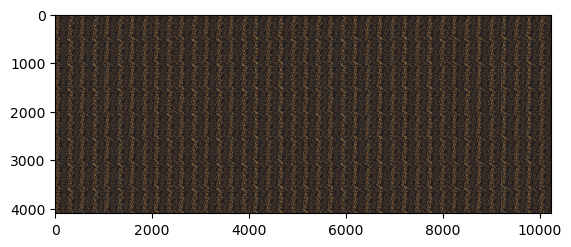

In [229]:
subject_rescale_percent = 100

selected_mask = cv2.cvtColor(cv2.imread('masks/{}/floor.png'.format(USRIMG)), cv2.COLOR_BGR2RGB)
# product_path = 'product_img/NeroSensation.jpg'
product_path1 = 'products/Stone/95_floral wallpaper texture-seamless.jpg'
product_path2 = 'products/Wallpapers/95_floral wallpaper texture-seamless.jpg'
product_path3 = 'products/Paints/95_floral wallpaper texture-seamless.jpg'

transformed_img = blender.implant_overlay(product_path2, 
                                    selected_mask,
                                    subject_rescale_percent,
                                    mode=1
                                    )

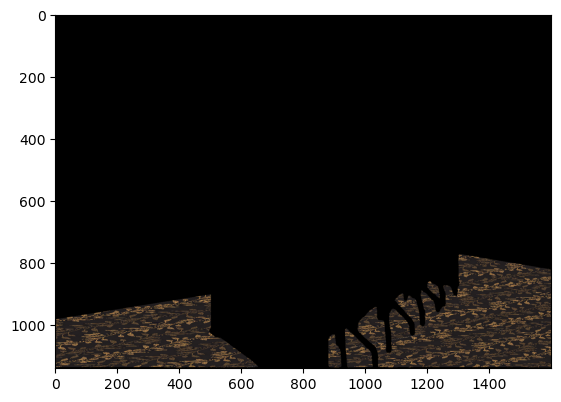

In [230]:
plt.imshow(transformed_img)